In [1]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True, as_frame=True)

In [ ]:
X["disease_progression"] = y
X
import pandas as pd
import os
from magpy.oracles.oracles import linear, BaseOracle
from magpy.search.pcskeleton import pc_skeleton, parallel_pc_skeleton
import logging
import networkx as nx
import matplotlib.pyplot as plt

try:
    _SETUP
except NameError:
    os.chdir("..")
    _SETUP = True


logging.basicConfig(level=logging.INFO)

print("running on folder: ", os.getcwd())
df = X.copy()
oracle._run("age", "disease_progression", ["bp"])
mat, sepset = pc_skeleton(oracle, df.columns)
G = nx.from_pandas_adjacency(mat)
nx.draw_circular(G, with_labels=True)
plt.show()
from magpy.search.astar import (
    AStarSearch,
    bic_score_node_poly,
    safe_run,
    bic_score_node,
)

astar = AStarSearch(X=df)

In [52]:
astar.run_scoring(func=safe_run(bic_score_node), parallel=False)

INFO:root:Scoring Nodes
INFO:root:Parent Set for age: {'s4', 'bp', 's5', 'bmi', 's2', 's6', 's1', 'disease_progression', 'sex', 's3'}
INFO:root:Include Parents for age: set()
INFO:root:Parents for age: {'s4', 'bp', 's5', 'bmi', 's2', 's6', 's1', 'disease_progression', 'sex', 's3'}
INFO:root:Parent Set for sex: {'s4', 'bp', 's5', 'bmi', 's2', 's6', 'age', 's1', 'disease_progression', 's3'}
INFO:root:Include Parents for sex: set()
INFO:root:Parents for sex: {'s4', 'bp', 's5', 'bmi', 's2', 's6', 'age', 's1', 'disease_progression', 's3'}
INFO:root:Parent Set for bmi: {'s4', 'bp', 's5', 's2', 's6', 'age', 's1', 'disease_progression', 'sex', 's3'}
INFO:root:Include Parents for bmi: set()
INFO:root:Parents for bmi: {'s4', 'bp', 's5', 's2', 's6', 'age', 's1', 'disease_progression', 'sex', 's3'}
INFO:root:Parent Set for bp: {'s4', 's5', 'bmi', 's2', 's6', 'age', 's1', 'disease_progression', 'sex', 's3'}
INFO:root:Include Parents for bp: set()
INFO:root:Parents for bp: {'s4', 's5', 'bmi', 's2', 

In [53]:
G = astar.search()

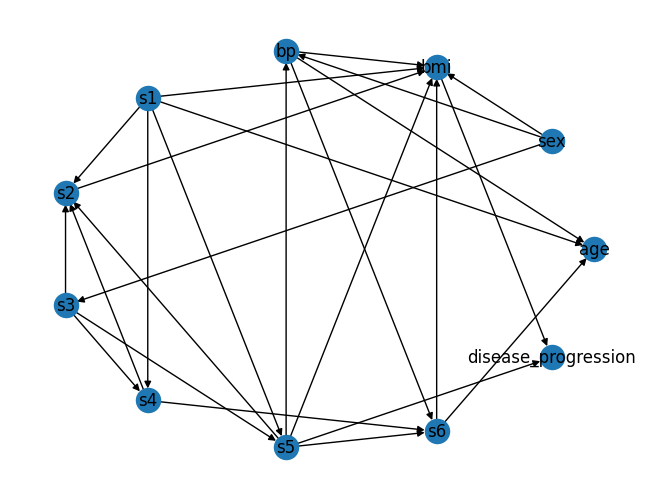

In [54]:
G = nx.from_pandas_adjacency(G, create_using=nx.DiGraph)
nx.draw_circular(G, with_labels=True)
plt.show()

In [55]:
from magpy.estimation.effects import (
    EffectEstimator,
    CategoricalTreatmentParams,
    CategoricalOutcomeParams,
    ContinuousTreatmentParams,
)
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

covariates = [
    "weather_1",
    "day_of_week",
    # "dph_col_grp_description",
    # "party1_move_pre_acc",
    # "party2_move_pre_acc",
    # "type_of_collision",
    # "road_cond_1",
]

effect_estimation = EffectEstimator(
    night_accidents,
    classifier=RandomForestClassifier,
    classifier_kwargs={"max_depth": 4},
    regressor=RandomForestRegressor,
    regressor_kwargs={"max_depth": 4},
)
results = effect_estimation.estimate_ate(
    treatment=CategoricalTreatmentParams(
        column="lighting",
        treatment_classes=["Dark - Street Lights"],
    ),
    outcome=CategoricalOutcomeParams(
        column="collision_severity",
        base_classes=["Fatal", "Injury (Severe)", "Injury (Other Visible)"],
    ),
    covariates=covariates,
    max_classes=5,
)

print(results.explain())

KeyboardInterrupt: 

In [263]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, clone
from sklearn.model_selection import cross_val_predict
from typing import List, Union, Optional
from scipy.special import expit, logit


def nn(x):
    return 1 / (numpy.sqrt(2 * numpy.pi)) * numpy.exp(-((x) ** 2) / 2)


class DebiasedML:
    """
    A class implementing Double/Debiased Machine Learning for treatment effect estimation.

    Parameters:
    -----------
    learner : BaseEstimator
        The base ML model to use for nuisance estimation (e.g., LGBMRegressor)
    cv_splits : int, default=5
        Number of cross-validation splits for nuisance estimation
    final_learner : Optional[BaseEstimator], default=None
        The ML model to use for final CATE estimation. If None, uses the same as learner

    Attributes:
    -----------
    debias_model_ : BaseEstimator
        Fitted model for debiasing treatment
    denoise_model_ : BaseEstimator
        Fitted model for denoising outcome
    final_model_ : BaseEstimator
        Fitted model for CATE estimation
    treatment_mean_ : float
        Mean of the treatment variable
    outcome_mean_ : float
        Mean of the outcome variable
    """

    def __init__(
        self,
        treatment_learner: BaseEstimator,
        outcome_learner: BaseEstimator,
        final_learner: Optional[BaseEstimator] = None,
        cv_splits: int = 5,
    ):
        self.treatment_learner = treatment_learner
        self.outcome_learner = outcome_learner
        self.final_learner = final_learner
        self.cv_splits = cv_splits
        self.epsilon = 1e-6
        self.outcome_type = None

    def fit(
        self,
        df: pd.DataFrame,
        treatment: str,
        outcome: str,
        covariates: List[str],
        outcome_type: str = "continuous",
    ) -> "DebiasedML":
        """
        Fit the Double/Debiased ML model.

        Parameters:
        -----------
        df : pd.DataFrame
            Input dataframe
        treatment : str
            Name of treatment column
        outcome : str
            Name of outcome column
        covariates : List[str]
            List of covariate column names

        Returns:
        --------
        self : DebiasedML
            The fitted model
        """
        # Store column names for later use
        self.treatment_ = treatment
        self.outcome_ = outcome
        self.covariates_ = covariates
        self.outcome_type = outcome_type

        # Store means for later use in counterfactual predictions
        self.treatment_mean_ = df[treatment].mean()
        self.outcome_mean_ = df[outcome].mean()

        # Create and fit the debiasing model for treatment
        self.debias_model_ = clone(self.treatment_learner)
        treatment_pred = cross_val_predict(
            self.debias_model_, df[covariates], df[treatment], cv=self.cv_splits
        )
        self.debias_model_.fit(df[covariates], df[treatment])

        # Modify the outcome prediction part based on outcome type
        self.denoise_model_ = clone(self.outcome_learner)
        if self.outcome_type in ["binary", "multiclass"]:
            # Get probability predictions instead of class predictions
            outcome_pred = cross_val_predict(
                self.denoise_model_,
                df[covariates],
                df[outcome],
                cv=self.cv_splits,
                method="predict_proba",  # Use probabilities for classification
            )
            # For binary, take only the positive class probability
            if self.outcome_type == "binary":
                outcome_pred = outcome_pred[:, 1]

            outcome_res = df[outcome] - outcome_pred

            # logloss = numpy.log(outcome_pred) * df[outcome] + numpy.log(
            #     1 - outcome_pred
            # ) * (1 - df[outcome])

            # outcome_res = (numpy.exp(-logloss) - 1) * (df[outcome] - 1 / 2) * 2

            # outcome_res = expit(outcome_res)

        else:  # continuous case
            outcome_pred = cross_val_predict(
                self.denoise_model_, df[covariates], df[outcome], cv=self.cv_splits
            )
            outcome_res = df[outcome] - outcome_pred

        self.denoise_model_.fit(df[covariates], df[outcome])

        # Calculate residuals
        treatment_res = df[treatment] - treatment_pred

        # Fit final CATE model using the R-learner approach
        weights = treatment_res**2

        signs = numpy.sign(treatment_res)
        tikhonov_adj = (1 - numpy.abs(signs)) * self.epsilon + signs * self.epsilon
        transformed_target = outcome_res / (treatment_res + tikhonov_adj)

        self.final_model_ = clone(self.final_learner)
        self.final_model_.fit(df[covariates], transformed_target, sample_weight=weights)

        return self

    def get_ite(self, df: pd.DataFrame) -> np.ndarray:
        """
        Get Individual Treatment Effects for new data.

        Parameters:
        -----------
        df : pd.DataFrame
            Dataframe containing covariates for prediction

        Returns:
        --------
        np.ndarray
            Array of individual treatment effects
        """
        if not hasattr(self, "final_model_"):
            raise ValueError("Model must be fitted before getting ITE")

        return self.final_model_.predict(df[self.covariates_])

    def counterfactual_prediction(
        self, df: pd.DataFrame, treatment_value: Union[float, np.ndarray]
    ) -> np.ndarray:
        """
        Make counterfactual predictions for specific treatment values.

        Parameters:
        -----------
        df : pd.DataFrame
            Dataframe containing covariates for prediction
        treatment_value : Union[float, np.ndarray]
            Treatment value(s) for counterfactual prediction

        Returns:
        --------
        np.ndarray
            Array of counterfactual predictions
        """
        if not hasattr(self, "final_model_"):
            raise ValueError(
                "Model must be fitted before making counterfactual predictions"
            )

        # Get baseline prediction
        if self.outcome_type == "binary":
            baseline = self.denoise_model_.predict_proba(df[self.covariates_])
            baseline = baseline[:, 1]

        elif self.outcome_type == "continuous":
            baseline = self.denoise_model_.predict(df[self.covariates_])

        # Get treatment effect
        ite = self.get_ite(df)

        # Calculate treatment deviation from mean
        if isinstance(treatment_value, (int, float)):
            treatment_dev = treatment_value - self.treatment_mean_
        else:
            treatment_dev = np.array(treatment_value) - self.treatment_mean_

        # Calculate counterfactual

        d = {
            "baseline": baseline,
            "addition": (ite * treatment_dev),
            "result": baseline + (ite * treatment_dev),
        }

        return d

In [329]:
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from numpy.random import normal


def get_data():
    k = 1
    N = 100_000
    z = normal(0, 1, N)
    x = z + normal(0, 1, N)
    y = z + k * x + normal(0, 1, N)
    yB = y > 0
    df = pandas.DataFrame({"z": z, "x": x, "y": yB, "y_c": y})

    return df


df = get_data()

print(df["y"].mean())

# Initialize the model
model = DebiasedML(
    treatment_learner=LGBMRegressor(),
    outcome_learner=LGBMClassifier(),
    final_learner=LGBMRegressor(),
    cv_splits=5,
)

# Fit the model
model.fit(
    df=df,
    treatment="x",
    outcome="y",
    covariates=["z"],
    outcome_type="binary",
)

# Get individual treatment effects
ite = model.get_ite(df)

# Make counterfactual predictions
# cf_pred = model.counterfactual_prediction(df, treatment_value=50)

0.49824
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Info] Start training from score 0.001201
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Info] Start training from score 0.003781
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tota

In [294]:
res = model.counterfactual_prediction(df=df, treatment_value=2)

In [299]:
(df["y_c"] + 1 > 1).mean() - (df["y_c"] > 1).mean()

0.18918000000000001

In [295]:
df["y"].mean()

0.56492

In [296]:
(res["addition"]).mean()

0.19378384614322294

In [292]:
res["result"].mean() - res["baseline"].mean()

0.026256429288702254

In [235]:
ite.mean()

0.027945690952334967

In [238]:
(df["y_c"] + 0.1 > 1).mean() - (df["y_c"] > 1).mean()

0.027109999999999967

In [530]:
train_df = df.sample(frac=0.5, random_state=42)
test_df = df.drop(train_df.index)

In [531]:
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

# Initialize the model
model = DebiasedML(
    treatment_learner=LinearRegression(),
    outcome_learner=LinearRegression(),
    final_learner=LinearRegression(),
    cv_splits=5,
)

# Fit the model
model.fit(
    df=train_df,
    treatment="age",
    outcome="disease_progression",
    covariates=["bmi", "bp"],
)

# Get individual treatment effects
ite = model.get_ite(test_df)

# Make counterfactual predictions
cf_pred = model.counterfactual_prediction(test_df, treatment_value=0)

KeyError: 'age'

In [30]:
test_df["cf_pred"] = cf_pred
test_df["cf_pred"].mean()

154.59084772832838

In [31]:
ite.mean()

125.80094742994571

In [532]:
import pandas

df = pandas.read_csv("data/diabetes.csv")

In [533]:
df["outcome"] = df["CLASS"] == "Y"

In [534]:
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

# Initialize the model
model = DebiasedML(
    treatment_learner=LGBMRegressor(),
    outcome_learner=LGBMClassifier(),
    final_learner=LGBMRegressor(),
    cv_splits=5,
)

# Fit the model
model.fit(
    df=df,
    treatment="BMI",
    outcome="outcome",
    covariates=["AGE"],
    outcome_type="binary",
)

# Get individual treatment effects
ite = model.get_ite(df)

# Make counterfactual predictions
cf_pred = model.counterfactual_prediction(df, treatment_value=50)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 1
[LightGBM] [Info] Start training from score 30.935100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [311]:
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from numpy.random import normal


def get_data():
    k = 0.3
    N = 100_000
    z = normal(0, 1, N)
    x = 1 * z + normal(0, 1, N)
    y = 1 * z + k * x + normal(0, 1, N)
    yB = y > 0
    df = pandas.DataFrame({"z": z, "x": x, "y": yB})

    return df


df = get_data()

# Initialize the model
model = DebiasedML(
    treatment_learner=LGBMRegressor(),
    outcome_learner=LGBMClassifier(),
    final_learner=LGBMRegressor(),
    cv_splits=5,
)

# Fit the model
model.fit(
    df=df,
    treatment="x",
    outcome="y",
    covariates=["z"],
    outcome_type="binary",
)

# Get individual treatment effects
ite = model.get_ite(df)

# Make counterfactual predictions
cf_pred = model.counterfactual_prediction(df, treatment_value=50)

numpy.exp(ite).mean()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Info] Start training from score 0.000893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Info] Start training from score 0.000347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

1.0757836493998312

In [310]:
df

,z,x,y
0,0.401731,-0.793020,True
1,-2.048442,-1.646158,False
2,0.173569,-0.442551,True
3,0.958120,0.306413,True
4,-0.545612,-1.540028,False
...,...,...,...
99995,-0.093600,-0.096106,True
99996,0.391440,-0.989830,False
99997,0.164485,0.773824,False
99998,-0.641621,-1.433162,False


0.12143650107261279

In [134]:
def prob_n_bigger_than_zero(kx):
    return (kx + normal(0, 1, 100_000) > 0).mean()

In [135]:
from matplotlib import pyplot as plt


z = [prob_n_bigger_than_zero(kx) for kx in numpy.arange(0, 1, 0.05)]

In [137]:
prob_n_bigger_than_zero(0.3)

0.61594

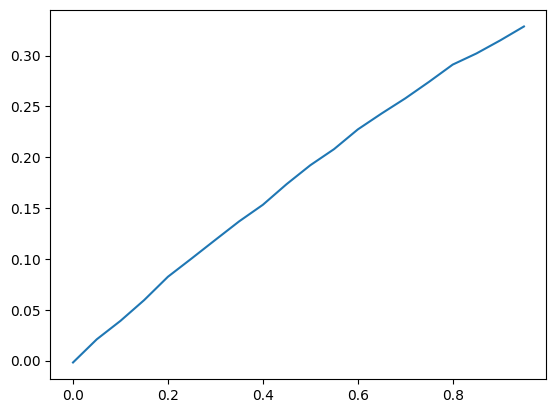

In [136]:
plt.plot(numpy.arange(0, 1, 0.05), numpy.array(z) - 0.5)

In [365]:
from magpy.estimation.effects import (
    EffectEstimator,
    CategoricalTreatmentParams,
    CategoricalOutcomeParams,
    ContinuousTreatmentParams,
    ContinuousOutcomeParams,
)

In [409]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np


class PolynomialRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, degree=2):
        self.degree = degree
        self.poly = PolynomialFeatures(degree=self.degree)
        self.linear = LinearRegression()

    def fit(self, X, y, sample_weight=None):
        # Reshape X if needed
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        # Transform features to polynomial features
        X_poly = self.poly.fit_transform(X)

        # Fit linear regression on polynomial features
        self.linear.fit(X_poly, y, sample_weight=sample_weight)
        return self

    def predict(self, X):
        # Reshape X if needed
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        # Transform features and predict
        X_poly = self.poly.transform(X)
        return self.linear.predict(X_poly)

In [524]:
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


def get_data():
    noise = 0.01
    k = 1
    N = 100_000
    z = normal(0, 1, N)
    x = 1 * z + normal(0, 1, N)
    y = 1 * z * z + k * x + normal(0, 1, N)
    yB = y > 0
    df = pandas.DataFrame({"z": z, "x": x, "y": yB, "y_c": y})

    return df


df = get_data()

effect_estimation = EffectEstimator(
    data=df,
    classifier=LGBMClassifier,
    regressor=PolynomialRegressor,
)

results = effect_estimation.fit_predict(
    treatment=ContinuousTreatmentParams(column="x"),
    # outcome=CategoricalOutcomeParams(column="y", base_classes=[False]),
    outcome=ContinuousOutcomeParams(column="y_c"),
    covariates=["z"],
)

In [525]:
results = effect_estimation.fit_predict(
    treatment=ContinuousTreatmentParams(column="x"),
    # outcome=CategoricalOutcomeParams(column="y", base_classes=[False]),
    outcome=ContinuousOutcomeParams(column="y_c"),
    covariates=["z"],
)

column='x' column='y_c'


/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


<Axes: xlabel='x', ylabel='effect'>

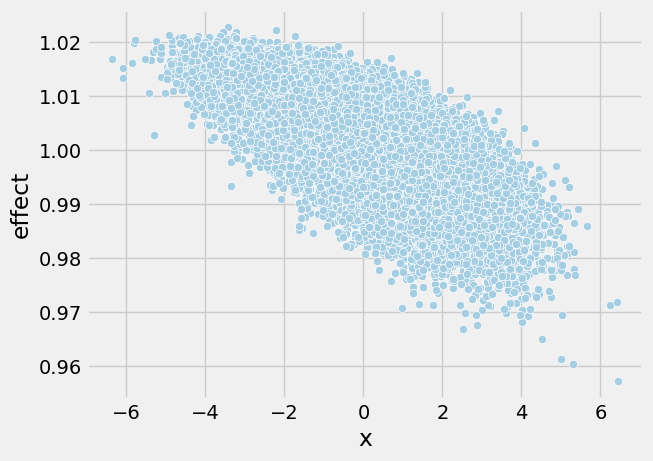

In [526]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.scatterplot(x="x", y="effect", data=results.data)

In [353]:
model = DebiasedML(
    treatment_learner=LGBMRegressor(),
    outcome_learner=LGBMClassifier(),
    final_learner=LGBMRegressor(),
    cv_splits=5,
)

# Fit the model
model.fit(
    df=df,
    treatment="x",
    outcome="y",
    covariates=["z"],
    outcome_type="binary",
)

# Get individual treatment effects
ite = model.get_ite(df)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Info] Start training from score 0.008249
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 1
[LightGBM] [Info] Start training from score 0.011305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

In [354]:
ite.mean()

0.16264227044086368

In [556]:
columns = ["Urea", "Cr", "HbA1c", "Chol", "TG", "HDL", "LDL", "VLDL", "BMI"]

In [564]:
from magpy.estimation.effects import EffectEstimator
from magpy.estimation.effects import (
    ITEResults,
    ContinuousOutcomeParams,
    ContinuousTreatmentParams,
    CategoricalOutcomeParams,
    CategoricalTreatmentParams,
)


df = pandas.read_csv("data/diabetes.csv")


effect_estimation = EffectEstimator(
    data=df,
    classifier=LGBMClassifier,
    regressor=LGBMRegressor,
)

results = {}
for col in columns:
    results[col] = effect_estimation.fit_predict(
        treatment=ContinuousTreatmentParams(column=col),
        # outcome=CategoricalOutcomeParams(column="y", base_classes=[False]),
        outcome=CategoricalOutcomeParams(column="CLASS", base_classes=["N"]),
        covariates=["AGE", "Gender"],
    )

column='Urea' column='CLASS' base_classes=['N'] treatment_classes=[]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 2
[LightGBM] [Info] Start training from score 5.259054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


column='Cr' column='CLASS' base_classes=['N'] treatment_classes=[]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 2
[LightGBM] [Info] Start training from score 70.142500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 2
[LightGBM] [Info] Start training from score 4.883025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


column='VLDL' column='CLASS' base_classes=['N'] treatment_classes=[]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 2
[LightGBM] [Info] Start training from score 1.802750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 2
[LightGBM] [Info] Start training from score 29.044375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/andre/magpy/src/magpy/estimation/effects.py:495: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouper = output_data.groupby("quantile")


In [568]:
for col in columns:
    print(col, results[col].data["effect"].mean())

Urea -0.010510280203178785
Cr -0.0007280056498469525
HbA1c 0.033135780602963724
Chol 0.027958361794905937
TG 0.027444438263924162
HDL -0.037377480685330026
LDL 0.0061118474383544345
VLDL 0.013718402143028762
BMI 0.02747977117625315


In [ ]:
results["BMI"]